In [1]:
from sklearn.metrics import accuracy_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import xgboost as xgb

In [2]:
df = pd.read_parquet('data-val.parquet')

In [3]:
# Dropping columns
df = df.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

In [4]:
# Replacing inf values with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
target_distribution = df['IS_BANCAS'].value_counts(normalize=True)
print(target_distribution)
class_counts = df['IS_BANCAS'].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  # Negative samples / Positive samples

IS_BANCAS
0.0    0.952381
1.0    0.047619
Name: proportion, dtype: float64


In [6]:
# Model

# Split data into features and target
X = df.drop(columns=['IS_BANCAS'])
y = df['IS_BANCAS']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss', 
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_lab = xgb_clf.predict(X_test)


/home/zeus/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:19:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred.round())
accuracy = round(accuracy, 4)
print("Model Accuracy:", str(accuracy*100) + "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred.round()))


Model Accuracy: 87.99%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     25995
         1.0       0.24      0.65      0.35      1347

    accuracy                           0.88     27342
   macro avg       0.61      0.77      0.64     27342
weighted avg       0.94      0.88      0.90     27342



In [8]:
roc_auc_score = roc_auc_score(y_test, y_pred)
gini_index = 2 * roc_auc_score - 1

print("ROC AUC Score:", roc_auc_score.round(2))
print("Gini Index:", gini_index.round(2))

ROC AUC Score: 0.86
Gini Index: 0.72


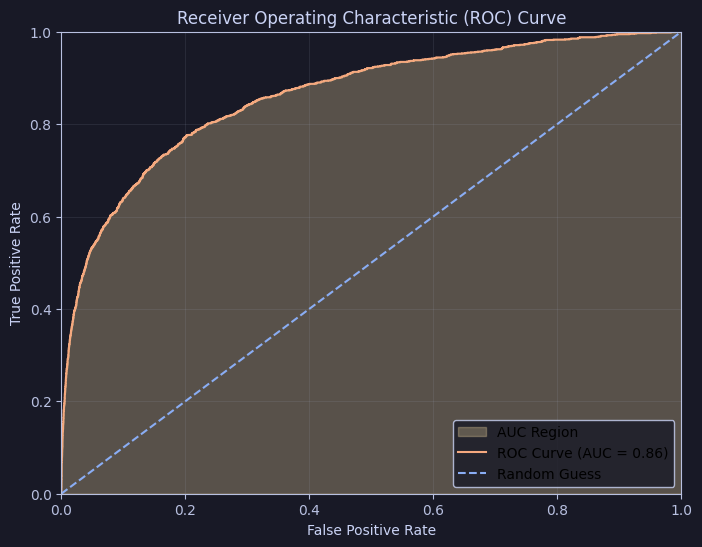

In [9]:

# Step 4: Evaluate predictions (e.g., ROC Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Insert the root point (0, 0) into fpr and tpr
fpr = [0] + list(fpr)  # Add 0 at the beginning of fpr
tpr = [0] + list(tpr)  # Add 0 at the beginning of tpr

# Define your custom background color
background_color = '#181926'  # A dark gray example, adjust as needed
text_colour = "#cad3f5"
axis_colour = "#b8c0e0"
roc_colour = '#f5a97f'
auc_colour = "#eed49f"
guess_colour = '#8aadf4'

plt.figure(figsize=(8, 6), facecolor=background_color)
ax = plt.gca()  # Get the current Axes
ax.set_facecolor(background_color)  # Set the background color of the Axes

# Customize axis colors
ax.tick_params(axis='x', colors=axis_colour)  # Set x-axis tick color
ax.tick_params(axis='y', colors=axis_colour)  # Set y-axis tick color
ax.spines['bottom'].set_color(axis_colour)  # Set bottom spine color
ax.spines['left'].set_color(axis_colour)    # Set left spine color
ax.spines['top'].set_color(axis_colour)  # Set bottom spine color
ax.spines['right'].set_color(axis_colour)    # Set left spine color

# Fill the area under the ROC curve
plt.fill_between(fpr, tpr, color=auc_colour, alpha=0.3, label='AUC Region')


# Plot the ROC curve
plt.plot(fpr, tpr, color=roc_colour, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=guess_colour, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', color=text_colour)  # White text for better contrast
plt.ylabel('True Positive Rate', color=text_colour)  # White text for better contrast
plt.title('Receiver Operating Characteristic (ROC) Curve', color=text_colour)
plt.legend(loc='lower right', facecolor=background_color, edgecolor=text_colour)
plt.grid(alpha=0.1, color=axis_colour)  # Adjust grid line color for visibility

# Set the x and y limits to start at 0
plt.xlim(0, 1)  # x-axis starts at 0
plt.ylim(0, 1)  # y-axis starts at 0

plt.show()